In [1]:
import sys
import random
import pprint
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import typing
from typing import Tuple, List
import nltk
from nltk.corpus import reuters
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [2]:


# Our corpus uses the following start and end tokens.
START_TOKEN = '<START>'
END_TOKEN = '<END>'

SEED = 1337
np.random.seed(SEED)
random.seed(SEED)

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc. It is therefore important to build some intuition as to their strengths and weaknesses. Here, we will explore two types of word vectors: those derived from co-occurrence matrices, and those derived via GloVe.

The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As Wikipedia states, "conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension".

##### Part 1: Count-Based Word Vectors
Most word vector models start from the following idea:

*You shall know a word by the company it keeps (Firth, J. R. 1957:11)*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, co-occurrence matrices.

##### Co-Occurrence
A co-occurrence matrix counts how often things co-occur in some environment. Given some word 𝑤𝑖 occurring in the document, we consider the context window surrounding 𝑤𝑖. Supposing our fixed window size is 𝑛, then this is the 𝑛 preceding and 𝑛 subsequent words in that document, i.e. words 𝑤𝑖−𝑛…𝑤𝑖−1 and 𝑤𝑖+1…𝑤𝑖+𝑛. We build a co-occurrence matrix 𝑀, which is a symmetric word-by-word matrix in which 𝑀𝑖𝑗 is the number of times 𝑤𝑗 appears inside 𝑤𝑖's window among all documents.

The rows (or columns) of a co-occurrence matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top 𝑘 *principal components*. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is 𝐴 with 𝑛 rows corresponding to 𝑛 words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal 𝑆 matrix, and our new, shorter length-𝑘 word vectors in 𝑈𝑘.

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

In [3]:
def read_corpus(category: str) -> List[List[str]]:
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


def distinct_words(corpus: List[List[str]]) -> Tuple[List[str], int]:
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted
            num_corpus_words (integer): number of distinct words across the corpus
    """
    # Flatten list of lists.
    flattened_list = [word for document in corpus for word in document]
    
    # Remove duplicates.
    corpus_words = set(flattened_list)
    
    num_corpus_words = len(corpus_words)

    return sorted(list(corpus_words)), num_corpus_words


def compute_co_occurrence_matrix(corpus: List[List[str]], window_size: int = 4) -> Tuple[np.matrix, dict]:
    """ Compute co-occurrence matrix for the given corpus and window_size.    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words i n the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)

    word2Ind = dict()    
    for idx, word in enumerate(words):
        word2Ind[word] = idx

    M = np.zeros((num_words, num_words))
    for document in corpus:
        for word_idx_in_doc, word in enumerate(document):
            indices_in_doc = list(range(word_idx_in_doc - window_size, word_idx_in_doc + window_size + 1))
            indices_in_doc = [x for x in indices_in_doc if x >= 0 and x <= (len(document)-1) and x != word_idx_in_doc]
            for i in indices_in_doc:
                matrix_idx_this_word = word2Ind[word]
                matrix_idx_neighbor = word2Ind[document[i]]
                M[(matrix_idx_this_word, matrix_idx_neighbor)] += 1

    return M, word2Ind


# Note: All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but
# only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides
# an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use
# sklearn.decomposition.TruncatedSVD.
def reduce_to_k_dim(M: np.matrix, k: int = 2) -> np.matrix:
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # X = sparse_random(100, 100, density=0.01, format='csr', random_state=SEED)
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=SEED)
    M_reduced = svd.fit_transform(M)
    
    print("Done.")
    return M_reduced


def plot_embeddings(M_reduced: np.matrix, word2Ind: dict, words: List[str]) -> None:
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus, 2)): matrix of 2-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    for i, word in enumerate(words):
        idx = word2Ind[word]
        x, y = M_reduced[idx]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    plt.show()
    
    return

In [4]:
reuters_corpus = read_corpus(category="crude")
# pprint.pprint(reuters_corpus[:3], compact=True, width=100)

corpus_words, num_corpus_words = distinct_words(reuters_corpus)

In [5]:
# ---------------------
# Sanity check to ensure the correctness of distinct_words()
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [6]:
# ---------------------
# Sanity check to ensure the correctness of compute_co_occurrence_matrix()
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2Ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [7]:
# ---------------------
# Sanity check to ensure that  M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Outputted Plot:


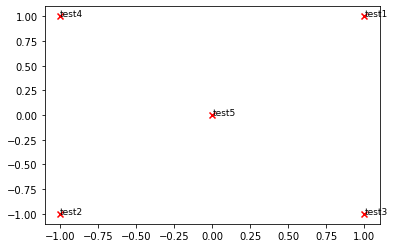

--------------------------------------------------------------------------------


In [8]:
# ---------------------
# Sanity check. The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis

Put together all the parts we have written. Compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" corpus. Then, use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). 
**Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


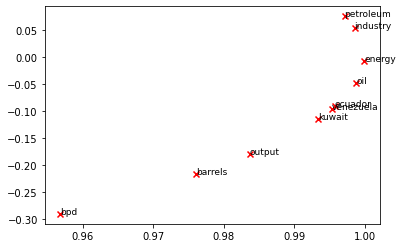

In [9]:
# -----------------------------
# Produce plot on Reuters data.
# ------------------------------
reuters_corpus = read_corpus(category='crude')
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length.
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']

plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

Note that countries are lumped together.

### Part 2: Prediction-Based Word Vectors (15 points)

More recently, prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

If this is your first time running these cells, i.e. download the embedding model, it will take about 15 minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [10]:
def load_embedding_model() -> KeyedVectors:
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [11]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take several minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
1. Put 10000 Glove vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [12]:
def get_matrix_of_vectors(wv_from_bin: KeyedVectors, required_words: list = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']) -> Tuple[np.matrix, dict]:
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(SEED)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [13]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible reason for causing the difference?

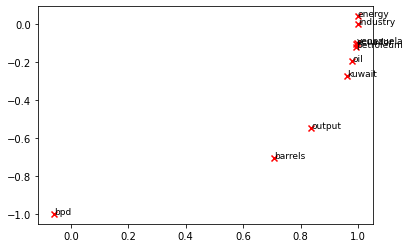

In [14]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced_normalized, word2Ind, words)

Countries are not grouped as tightly together as previously. Petroleum and oil are closer to one another, which makes sense, as they essentially convey the same meaning. One also finds energy and industry being embedded more closely together, which one can find reasonable as both terms refer to the meta-level (the energy industry).

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

#### Question 2.2: Words with Multiple Meanings
Polysemes and homonyms are words that have more than one meaning ([wiki page](https://en.wikipedia.org/wiki/Polysemy)). Find a word with at least 2 different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [21]:
def get_top_10_similar_words(input_word):
    wv_from_bin.most_similar(input_word)

    return top_10_similar_words

words = ['board', 'bank', 'leaves', 'bear', 'right']
for word in words:
    print(word, *wv_from_bin.most_similar(word), sep='\n')
    print()

board
('boards', 0.6880484223365784)
('directors', 0.6878399848937988)
('commission', 0.6532573103904724)
('trustees', 0.6526336669921875)
('executive', 0.6468799710273743)
('commissioners', 0.6252285242080688)
('council', 0.6131470203399658)
('committee', 0.6117008924484253)
('chairman', 0.5796202421188354)
('panel', 0.5716795325279236)

bank
('banks', 0.7625691890716553)
('banking', 0.6818838119506836)
('central', 0.6283639669418335)
('financial', 0.6166563034057617)
('credit', 0.6049750447273254)
('lending', 0.5980608463287354)
('monetary', 0.5963002443313599)
('bankers', 0.5913101434707642)
('loans', 0.5802938938140869)
('investment', 0.5740202069282532)

leaves
('ends', 0.6128067970275879)
('leaf', 0.6027014851570129)
('stems', 0.5998532176017761)
('takes', 0.5902854800224304)
('leaving', 0.5761634111404419)
('grows', 0.5663397312164307)
('flowers', 0.5600922107696533)
('turns', 0.5536050796508789)
('leave', 0.5496848821640015)
('goes', 0.5434924960136414)

bear
('bears', 0.684942

Two good examples of homonyms in our corpus include:
- leaves (with the meaning of tree leaves and leaving respectively);
- right (with the meaning of correct and the direction respectively).

Three homonyms present in our corpus which do *not* show multiple meanings in the top-10 words by cosine similarity includes:
- board (only the "board of directors" meaning shows up, not the "plank" kind of board);
- bank (only the financial institution shows up, not the river bank meaning of the word).

A semi-good example includes:
- bear (mainly in the meaning of the animal, although we also get "bearing").

The reason for our results can be traced back to the nature of our corpus. It is collected from Reuters. Therefore, it is biased towards newsworthy words, i.e. financial institutions over river banks.

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [27]:
word = 'begin'
synonyms = ['commence', 'start', 'initiate']
antonyms = ['terminate', 'finish', 'stop', 'halt', 'conclude', 'cease']

print('synonyms')
for synonym in synonyms:
    print(f'{word, synonym} \t {wv_from_bin.distance(word, synonym)}')

print('antonyms')
for antonym in antonyms:
    print(f'{word, antonym} \t {wv_from_bin.distance(word, antonym)}')


synonyms
('begin', 'commence') 	 0.42311644554138184
('begin', 'start') 	 0.19364678859710693
('begin', 'initiate') 	 0.6234182119369507
antonyms
('begin', 'terminate') 	 0.7202378213405609
('begin', 'finish') 	 0.5839853882789612
('begin', 'stop') 	 0.42383432388305664
('begin', 'halt') 	 0.5599273443222046
('begin', 'conclude') 	 0.4550349712371826
('begin', 'cease') 	 0.5645579099655151


We see that 'begin' and 'initiate' have a relatively large Cosine Distance of 0.623 even though they can be considered synonyms.

More interestingly, we see also that 'begin' and 'stop' display a Cosine Distance of 0.424, which is significantly smaller than the Cosine Distance between 'begin' and 'initiate', even though 'begin' and 'stop' are direct antonyms.

One explanation to the counter-intuitive result is the possibility that 'begin' and 'stop' show up together frequently. Since they would often be found in the same context, they would be mapped to a similar point in our multi-dimensional word-embedding space.

For example, antonyms could be used in the same sentence to compare two things. For this reason, GloVe could result in these antonyms having a relatively small cosine distance.